In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [2]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [3]:
df.iloc[:, 0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [4]:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [5]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [6]:
df1 = pd.DataFrame()
df1['a'] = [1, 2, 3, 4]
df1

,a
0,1
1,2
2,3
3,4


In [7]:
df1['b'] = [10, 20, 30, 40]
df1

,a,b
0,1,10
1,2,20
2,3,30
3,4,40


In [8]:
df1['a'] + df1['b']

0    11
1    22
2    33
3    44
dtype: int64

# Constructing a DataBlock

In [9]:
dblock = DataBlock()

In [10]:
dsets = dblock.datasets(df)

In [11]:
dsets.train[0]

(fname       003606.jpg
 labels             car
 is_valid          True
 Name: 1813, dtype: object,
 fname       003606.jpg
 labels             car
 is_valid          True
 Name: 1813, dtype: object)

In [12]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [13]:
x, y = dsets.train[0]
x, y

(fname       003606.jpg
 labels             car
 is_valid          True
 Name: 1813, dtype: object,
 fname       003606.jpg
 labels             car
 is_valid          True
 Name: 1813, dtype: object)

In [14]:
#path

In [15]:
Path.BASE_PATH = path

In [16]:
path

Path('.')

In [17]:
# lambda are not compatible with serialization
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
# dblock = DataBlock(get_x = lambda r: path/'train'/r['fname'], get_y = lambda r: r['labels'])
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('train/003519.jpg'), ['bird'])

In [18]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x,
                   get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=375x500,
 TensorMultiCategory([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.]))

In [19]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['bus','person']

In [20]:
dsets.vocab

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [21]:
# is_valid as in a validation set
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [22]:
tt,vv=splitter(df)

In [23]:
len(tt), len(vv)

(2501, 2510)

In [24]:
list(zip(tt,vv))[-1]

(5010, 4992)

In [25]:
(~df['is_valid'][1:10]).tolist()

[False, False, True, False, True, False, False, False, True]

In [26]:
(df['is_valid'][1:10]).tolist()

[True, True, False, True, False, True, True, True, False]

In [27]:
df[1:10]

,fname,labels,is_valid
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
5,000017.jpg,person horse,False
6,000019.jpg,cat,True
7,000020.jpg,car,True
8,000021.jpg,dog person,True
9,000023.jpg,bicycle person,False


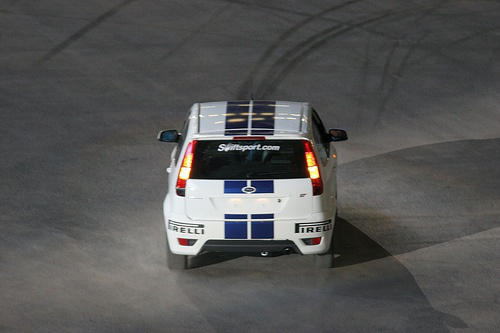

In [28]:
Image.open(path/'train'/df['fname'][3])

In [29]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
# dls = dblock.dataloaders(df, bs=32)
dls = dblock.dataloaders(df)

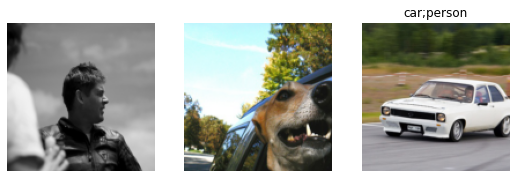

In [30]:
dls.show_batch(nrows=1, ncols=3)

# Binary Cross Entropy

In [31]:
learn = cnn_learner(dls, resnet18)

In [32]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [33]:
activs[0]

tensor([ 1.2208, -1.3111, -2.4230, -0.5111, -1.4885, -0.6625,  0.3143, -1.8345,
        -1.1233, -0.4226, -1.7289, -0.9490,  0.6764, -0.2055,  0.7638,  0.4331,
        -1.2431,  2.3520, -1.0169,  4.3973], grad_fn=<SelectBackward>)

In [34]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).log().mean()

In [35]:
binary_cross_entropy(activs, y)

TensorMultiCategory(-1.0950, grad_fn=<AliasBackward>)

In [36]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0140, grad_fn=<AliasBackward>)

In [37]:
# partial by example
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello("Jeremy"), say_hello("Jeremy", "Ahoy!")

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [38]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"), f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [39]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.948295,0.699825,0.235498,00:12
1,0.824821,0.561895,0.289084,00:08
2,0.607684,0.206065,0.809143,00:08
3,0.361582,0.124849,0.942012,00:08


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.135094,0.120411,0.946773,00:10
1,0.119112,0.107985,0.954024,00:10
2,0.099212,0.103130,0.950976,00:10


In [40]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.944158,0.702194,0.615239,00:08
1,0.817664,0.547156,0.748028,00:09
2,0.602808,0.204490,0.948187,00:08
3,0.361483,0.124671,0.957689,00:08


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.135363,0.115138,0.959721,00:10
1,0.117176,0.109233,0.961713,00:10
2,0.097943,0.104375,0.963247,00:10


In [41]:
preds, targs = learn.get_preds()

In [42]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorMultiCategory(0.9559)

In [43]:
xs = torch.linspace(0.05, 0.95, 29)

In [44]:
xs

tensor([0.0500, 0.0821, 0.1143, 0.1464, 0.1786, 0.2107, 0.2429, 0.2750, 0.3071,
        0.3393, 0.3714, 0.4036, 0.4357, 0.4679, 0.5000, 0.5321, 0.5643, 0.5964,
        0.6286, 0.6607, 0.6929, 0.7250, 0.7571, 0.7893, 0.8214, 0.8536, 0.8857,
        0.9179, 0.9500])

In [45]:
preds.shape

torch.Size([2510, 20])

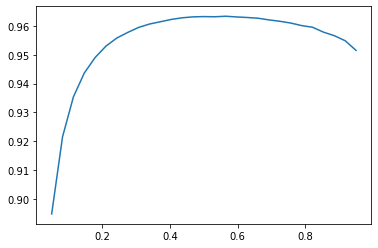

In [46]:
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs);

In [47]:
# list(zip(accs, xs.tolist()))

In [48]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [49]:
Path.BASE_PATH = path

In [50]:
path.ls()

(#50) [Path('19'),Path('06'),Path('13'),Path('07'),Path('08.obj'),Path('14.obj'),Path('19.obj'),Path('io_sample.cpp'),Path('16.obj'),Path('15')...]

In [51]:
img_files = get_image_files(path)

In [52]:
img_files

(#15678) [Path('19/frame_00340_rgb.jpg'),Path('19/frame_00069_rgb.jpg'),Path('19/frame_00090_rgb.jpg'),Path('19/frame_00206_rgb.jpg'),Path('19/frame_00501_rgb.jpg'),Path('19/frame_00231_rgb.jpg'),Path('19/frame_00329_rgb.jpg'),Path('19/frame_00112_rgb.jpg'),Path('19/frame_00353_rgb.jpg'),Path('19/frame_00151_rgb.jpg')...]

In [53]:
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('19/frame_00340_pose.txt')

In [54]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

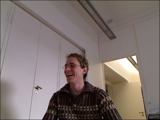

In [55]:
im.to_thumb(160)

In [56]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [57]:
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [58]:
ctr = np.genfromtxt(img2pose(img_files[0]), skip_header=3)
ctr

array([ -34.5029,   55.4928, 1036.74  ])

In [59]:
cal[0][0]

517.679

In [60]:
c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
c1

302.77154660850357

In [61]:
get_ctr(img_files[0])

tensor([302.7715, 268.2094])

In [62]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13')
#     batch_tfms=[*aug_transforms(size=(240,320)), 
#                 Normalize.from_stats(*imagenet_stats)]
)

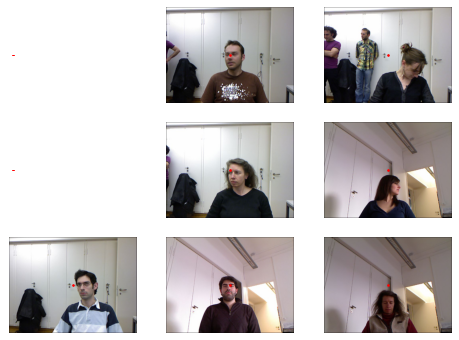

In [63]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [64]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 480, 640]), torch.Size([64, 1, 2]))

In [65]:
yb[0]

TensorPoint([[0.0635, 0.1512]], device='cuda:0')

In [66]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet18, y_range=(-1,1)).to_fp16()

In [67]:
def sigmoid_range(x, lo, hi):
    return torch.sigmoid(x) * (hi-lo) + lo
t = torch.linspace(-8, 8, 1)

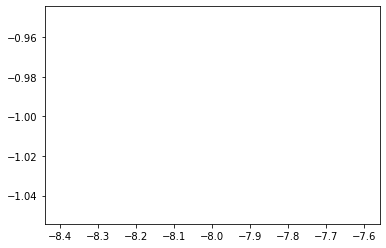

In [68]:
plt.plot(t, sigmoid_range(t, -1, 1));

In [69]:
dls.loss_func

FlattenedLoss of MSELoss()

In [70]:
# learn.lr_find()

In [71]:
# lr = 2e-2
# learn.fit_one_cycle(5, lr)